# Installing dependencies

In [1]:
!pip install geopandas
!pip install sentinelhub
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 60.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 70.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.4/244.4 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.8/131.8 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 31.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 7.6 MB/s eta 0:00:00
  Created wheel for utm: filename=utm-0.7.0-py3-none-any.whl size=6085 sha256=ff81972eb53868f1cbda104fbf18ffc24623c5942eae76070f6dea9957aa5670
  Stored in directory: /root/.cache/pip/wheels/2f/a1/c8/54

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 44.4 MB/s eta 0:00:00


# Specifying file tree

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

dataset_name = 'dlr_fusion_competition_germany'
sentinel2_name = f'{dataset_name}_train_source_sentinel_2'
labels_name = f'{dataset_name}_train_labels'
download_path = os.path.join('.', 'germany_sentinel2_data')

data_coords = '33N_18E_242N'
geojson_dir = os.path.join(download_path, labels_name, f'{labels_name}_{data_coords}')
bands_dir = os.path.join(download_path, sentinel2_name, f'{sentinel2_name}_{data_coords}_2018')

# Pulling data from hub

In [4]:
!pip install radiant_mlhub
!mlhub configure

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 73.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.4/137.4 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 92.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 11.1 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.65.0
    Uninstalling tqdm-4.65.0:
      Successfully uninstalled tqdm-4.65.0
  Attempting uninstall: shapely
    Found existing installation: shapely 2.0.1
    Uninstalling shapely-2.0.1:
      Successfully uninstalled shapely-2.0.1
  Attempting uninstall: pydantic
    Found existing installation: pydantic 1.10.7
    Uninstalling pydantic-1.10.7:
      Successfully uninstalled pydantic-1.10.7
API Key: de0e55f018c24b847309f8b1

In [5]:
from radiant_mlhub import Collection, Dataset

ds = Dataset.fetch(dataset_name)
for collection in ds.collections:
    if collection.id in [labels_name, sentinel2_name]:
      archive_path = collection.download(download_path)

  0%|          | 0/11835.6 [00:00<?, ?M/s]

  0%|          | 0/2.3 [00:00<?, ?M/s]

In [6]:
import tarfile
from glob import glob

for gz in glob(os.path.join(download_path, "*.gz")):
    #unpacking
    print(f"unzipping {gz} to {download_path}")
    tar = tarfile.open(gz, "r:gz")
    tar.extractall(download_path)
    tar.close()
    #cleaning up
    os.remove(gz)

unzipping ./germany_sentinel2_data/dlr_fusion_competition_germany_train_source_sentinel_2.tar.gz to ./germany_sentinel2_data
unzipping ./germany_sentinel2_data/dlr_fusion_competition_germany_train_labels.tar.gz to ./germany_sentinel2_data


# Defining Keras Data Sequence

In [7]:
from tensorflow import keras
import math
from random import shuffle, seed
import pickle
import geopandas as gpd
import numpy as np
import rasterio as rio
from rasterio import features

CLASSES = ["Wheat", "Rye", "Barley", "Oats", "Corn", "Oil Seeds", "Root Crops", "Meadows", "Forage Crops"]
CROP_IDS = [1, 2, 3, 4, 5, 6, 7, 8, 9]
min_area=1000
geojson_filename = 'labels.geojson'
labelgeojson=os.path.join(geojson_dir, geojson_filename)


with open(os.path.join(bands_dir, "bbox.pkl"), 'rb') as f:
    bbox = pickle.load(f)
    crs = str(bbox.crs)
    minx, miny, maxx, maxy = bbox.min_x, bbox.min_y, bbox.max_x, bbox.max_y

labels = gpd.read_file(labelgeojson)
labels = labels.to_crs(crs)

mask = labels.geometry.area > min_area
print(f"ignoring {(~mask).sum()}/{len(mask)} fields with area < {min_area}m2")
labels = labels.loc[mask]

bands = np.load(os.path.join(bands_dir, "bands.npy"), mmap_mode='r')

clp = np.load(os.path.join(bands_dir, "clp.npy"), mmap_mode='r')

temporal_length, width, height, bands_count = bands.shape

transform = rio.transform.from_bounds(minx, miny, maxx, maxy, width, height)

crop_mask = features.rasterize(
    zip(labels.geometry, labels.crop_id), all_touched=True,
    transform=transform, out_shape=(width, height)
).astype('uint8')

assert len(np.unique(crop_mask)) > 0, f"vectorized fid mask contains no fields. " \
    f"Does the label geojson {geojson_filename} cover the region defined by {bands_dir}?"

ignoring 30/2534 fields with area < 1000m2


In [8]:
class Sentinel2Data(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, img_size, batch_size, bands, mask, indexes, required_bands=[1, 4, 5]):
        self.image_size = img_size
        self.batch_size = batch_size
        self.bands = bands
        self.mask = crop_mask
        self.indexes = indexes
        self.required_bands = required_bands
    def on_epoch_end(self):
        shuffle(self.indexes)

    def __len__(self):
        return len(self.indexes) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        idx_start = idx * self.batch_size
        idx_end = idx_start + self.batch_size
        if idx_end > len(self)*self.batch_size:
          idx_end = len(self)*self.batch_size
          idx_start = idx_end-self.batch_size

        batch_idxs = self.indexes[idx_start:idx_end]

        x = np.zeros(shape=(len(batch_idxs), self.image_size[0], self.image_size[1], len(self.required_bands)), dtype='float32')
        y = np.zeros(shape=(len(batch_idxs), self.image_size[0], self.image_size[1]), dtype='uint8')

        for i in range(len(batch_idxs)):
            temporal_i, row_bounds, col_bounds = batch_idxs[i]

            for j in range(len(self.required_bands)):
                band_j = self.required_bands[j]
                x[i, ..., j] = self.bands[temporal_i, row_bounds[0]:row_bounds[1], col_bounds[0] : col_bounds[1], band_j] / 21412.0
            y[i] = self.mask[row_bounds[0]:row_bounds[1], col_bounds[0] : col_bounds[1]]

        return x, y

In [9]:
sample_shape=(256,256)

samples_in_row = math.ceil(width / sample_shape[0])
samples_in_col = math.ceil(height / sample_shape[1])

indexes = []
for temporal_index in range(temporal_length):
    for y_i in range(samples_in_col):
        col_start = y_i * sample_shape[1]
        col_end = col_start + sample_shape[1]

        if col_end > height:
            col_start = width - sample_shape[1]
            col_end = height

        for x_i in range(samples_in_row):
            row_start = x_i * sample_shape[0]
            row_end = row_start + sample_shape[0]

            if row_end > width:
                row_start = width - sample_shape[0]
                row_end = width

            mean_clp = np.mean(clp[temporal_index, row_start:row_end, col_start : col_end, 0] / 255.)
            if mean_clp < 0.4:
                indexes.append((temporal_index, (row_start, row_end), (col_start, col_end)))

seed(2023)
shuffle(indexes)

In [10]:
validation_split=0.7
split_index = math.ceil(len(indexes) * validation_split)
train_seq = Sentinel2Data(img_size=sample_shape, batch_size=4, bands=bands, mask=crop_mask, indexes=indexes[:split_index])
val_seq = Sentinel2Data(img_size=sample_shape, batch_size=4, bands=bands, mask=crop_mask, indexes=indexes[split_index:])

print(len(train_seq))
print(len(val_seq))

942
403


942
(256, 256, 3)
(256, 256)


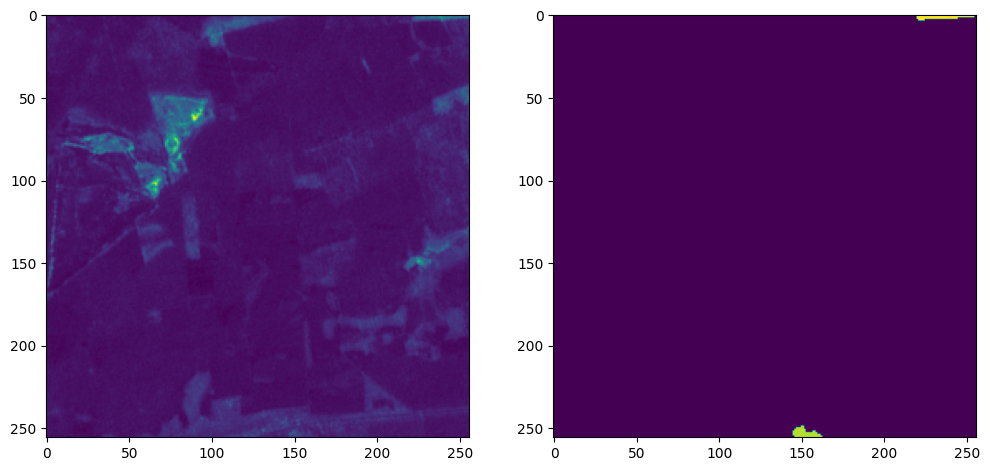

In [11]:
import matplotlib.pyplot as plt

batch_sample = train_seq[0][0]

smp_idx = 0
img_sample = batch_sample[smp_idx]
mask_sample = train_seq[0][1][smp_idx]

print(len(train_seq))
print(img_sample.shape)
print(mask_sample.shape)


figure, axarr = plt.subplots(1, 2)
figure.set_size_inches((12,12))

axarr[0].imshow(img_sample[..., 0])
axarr[1].imshow(mask_sample)

plt.show()

# Model definition

In [12]:
import tensorflow as tf
import tensorflow.keras as k


def conv_block(x, kernels, kernel_size=(3, 3), strides=(1, 1), padding='same',
               is_bn=True, is_relu=True, n=2):
    """ Custom function for conv2d:
        Apply  3*3 convolutions with BN and relu.
    """
    for i in range(1, n + 1):
        x = k.layers.Conv2D(filters=kernels, kernel_size=kernel_size,
                            padding=padding, strides=strides,
                            kernel_regularizer=tf.keras.regularizers.l2(1e-4),
                            kernel_initializer=k.initializers.he_normal(seed=5))(x)
        if is_bn:
            x = k.layers.BatchNormalization()(x)
        if is_relu:
            x = k.activations.relu(x)

    return x

def unet3plus(input_shape, output_channels):
    """ UNet3+ base model """
    filters = [64, 128, 256, 512, 1024]

    input_layer = k.layers.Input(
        shape=input_shape,
        name="input_layer"
    )  # 320*320*3

    """ Encoder"""
    # block 1
    e1 = conv_block(input_layer, filters[0])  # 320*320*64

    # block 2
    e2 = k.layers.MaxPool2D(pool_size=(2, 2))(e1)  # 160*160*64
    e2 = conv_block(e2, filters[1])  # 160*160*128

    # block 3
    e3 = k.layers.MaxPool2D(pool_size=(2, 2))(e2)  # 80*80*128
    e3 = conv_block(e3, filters[2])  # 80*80*256

    # block 4
    e4 = k.layers.MaxPool2D(pool_size=(2, 2))(e3)  # 40*40*256
    e4 = conv_block(e4, filters[3])  # 40*40*512

    # block 5
    # bottleneck layer
    e5 = k.layers.MaxPool2D(pool_size=(2, 2))(e4)  # 20*20*512
    e5 = conv_block(e5, filters[4])  # 20*20*1024

    """ Decoder """
    cat_channels = filters[0]
    cat_blocks = len(filters)
    upsample_channels = cat_blocks * cat_channels

    """ d4 """
    e1_d4 = k.layers.MaxPool2D(pool_size=(8, 8))(e1)  # 320*320*64  --> 40*40*64
    e1_d4 = conv_block(e1_d4, cat_channels, n=1)  # 320*320*64  --> 40*40*64

    e2_d4 = k.layers.MaxPool2D(pool_size=(4, 4))(e2)  # 160*160*128 --> 40*40*128
    e2_d4 = conv_block(e2_d4, cat_channels, n=1)  # 160*160*128 --> 40*40*64

    e3_d4 = k.layers.MaxPool2D(pool_size=(2, 2))(e3)  # 80*80*256  --> 40*40*256
    e3_d4 = conv_block(e3_d4, cat_channels, n=1)  # 80*80*256  --> 40*40*64

    e4_d4 = conv_block(e4, cat_channels, n=1)  # 40*40*512  --> 40*40*64

    e5_d4 = k.layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(e5)  # 80*80*256  --> 40*40*256
    e5_d4 = conv_block(e5_d4, cat_channels, n=1)  # 20*20*1024  --> 20*20*64

    d4 = k.layers.concatenate([e1_d4, e2_d4, e3_d4, e4_d4, e5_d4])
    d4 = conv_block(d4, upsample_channels, n=1)  # 40*40*320  --> 40*40*320

    """ d3 """
    e1_d3 = k.layers.MaxPool2D(pool_size=(4, 4))(e1)  # 320*320*64 --> 80*80*64
    e1_d3 = conv_block(e1_d3, cat_channels, n=1)  # 80*80*64 --> 80*80*64

    e2_d3 = k.layers.MaxPool2D(pool_size=(2, 2))(e2)  # 160*160*256 --> 80*80*256
    e2_d3 = conv_block(e2_d3, cat_channels, n=1)  # 80*80*256 --> 80*80*64

    e3_d3 = conv_block(e3, cat_channels, n=1)  # 80*80*512 --> 80*80*64

    e4_d3 = k.layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(d4)  # 40*40*320 --> 80*80*320
    e4_d3 = conv_block(e4_d3, cat_channels, n=1)  # 80*80*320 --> 80*80*64

    e5_d3 = k.layers.UpSampling2D(size=(4, 4), interpolation='bilinear')(e5)  # 20*20*320 --> 80*80*320
    e5_d3 = conv_block(e5_d3, cat_channels, n=1)  # 80*80*320 --> 80*80*64

    d3 = k.layers.concatenate([e1_d3, e2_d3, e3_d3, e4_d3, e5_d3])
    d3 = conv_block(d3, upsample_channels, n=1)  # 80*80*320 --> 80*80*320

    """ d2 """
    e1_d2 = k.layers.MaxPool2D(pool_size=(2, 2))(e1)  # 320*320*64 --> 160*160*64
    e1_d2 = conv_block(e1_d2, cat_channels, n=1)  # 160*160*64 --> 160*160*64

    e2_d2 = conv_block(e2, cat_channels, n=1)  # 160*160*256 --> 160*160*64

    d3_d2 = k.layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(d3)  # 80*80*320 --> 160*160*320
    d3_d2 = conv_block(d3_d2, cat_channels, n=1)  # 160*160*320 --> 160*160*64

    d4_d2 = k.layers.UpSampling2D(size=(4, 4), interpolation='bilinear')(d4)  # 40*40*320 --> 160*160*320
    d4_d2 = conv_block(d4_d2, cat_channels, n=1)  # 160*160*320 --> 160*160*64

    e5_d2 = k.layers.UpSampling2D(size=(8, 8), interpolation='bilinear')(e5)  # 20*20*320 --> 160*160*320
    e5_d2 = conv_block(e5_d2, cat_channels, n=1)  # 160*160*320 --> 160*160*64

    d2 = k.layers.concatenate([e1_d2, e2_d2, d3_d2, d4_d2, e5_d2])
    d2 = conv_block(d2, upsample_channels, n=1)  # 160*160*320 --> 160*160*320

    """ d1 """
    e1_d1 = conv_block(e1, cat_channels, n=1)  # 320*320*64 --> 320*320*64

    d2_d1 = k.layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(d2)  # 160*160*320 --> 320*320*320
    d2_d1 = conv_block(d2_d1, cat_channels, n=1)  # 160*160*320 --> 160*160*64

    d3_d1 = k.layers.UpSampling2D(size=(4, 4), interpolation='bilinear')(d3)  # 80*80*320 --> 320*320*320
    d3_d1 = conv_block(d3_d1, cat_channels, n=1)  # 320*320*320 --> 320*320*64

    d4_d1 = k.layers.UpSampling2D(size=(8, 8), interpolation='bilinear')(d4)  # 40*40*320 --> 320*320*320
    d4_d1 = conv_block(d4_d1, cat_channels, n=1)  # 320*320*320 --> 320*320*64

    e5_d1 = k.layers.UpSampling2D(size=(16, 16), interpolation='bilinear')(e5)  # 20*20*320 --> 320*320*320
    e5_d1 = conv_block(e5_d1, cat_channels, n=1)  # 320*320*320 --> 320*320*64

    d1 = k.layers.concatenate([e1_d1, d2_d1, d3_d1, d4_d1, e5_d1, ])
    d1 = conv_block(d1, upsample_channels, n=1)  # 320*320*320 --> 320*320*320

    # last layer does not have batchnorm and relu
    d = conv_block(d1, output_channels, n=1, is_bn=False, is_relu=False)

    output = k.activations.softmax(d)

    return tf.keras.Model(inputs=input_layer, outputs=[output], name='UNet_3Plus')

In [13]:
tf.compat.v1.reset_default_graph()
model = unet3plus(
    img_sample.shape,
    len(CLASSES)+1,
)

model.summary()

Model: "UNet_3Plus"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_layer[0][0]']            
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                        

# Train

Epoch 1/12
942/942 [==============================] - 1125s 1s/step - loss: 2.7197 - sparse_categorical_accuracy: 0.5283 - val_loss: 2.5956 - val_sparse_categorical_accuracy: 0.5419
Epoch 2/12
942/942 [==============================] - 1078s 1s/step - loss: 2.4698 - sparse_categorical_accuracy: 0.5800 - val_loss: 2.3456 - val_sparse_categorical_accuracy: 0.6057
Epoch 3/12
942/942 [==============================] - 1079s 1s/step - loss: 2.0762 - sparse_categorical_accuracy: 0.7066 - val_loss: 1.9183 - val_sparse_categorical_accuracy: 0.7599
Epoch 4/12
942/942 [==============================] - 1081s 1s/step - loss: 1.5937 - sparse_categorical_accuracy: 0.8570 - val_loss: 1.5767 - val_sparse_categorical_accuracy: 0.8538
Epoch 5/12
942/942 [==============================] - 1081s 1s/step - loss: 1.3974 - sparse_categorical_accuracy: 0.9056 - val_loss: 1.4150 - val_sparse_categorical_accuracy: 0.8920
Epoch 6/12
942/942 [==============================] - 1081s 1s/step - loss: 1.2856 - spars

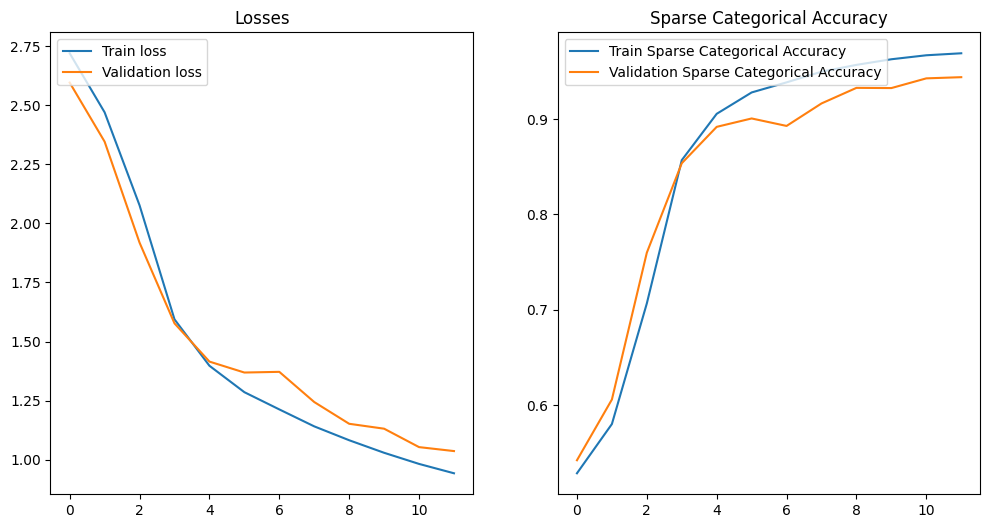

In [15]:
optim = tf.keras.optimizers.experimental.SGD(learning_rate=0.01, momentum=0.9, weight_decay=0.0001)
model.compile(
    optimizer=optim, 
    loss=keras.losses.SparseCategoricalCrossentropy(),
     metrics=[
        'sparse_categorical_accuracy',
    ]
)

callbacks = [
    keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/dimploma/unet3plus_test/unet3plus_acc_{val_sparse_categorical_accuracy:.4f}.h5", save_best_only=True, monitor='val_sparse_categorical_accuracy', mode='max'),
    keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=3),
]

training = model.fit(train_seq, validation_data=val_seq, epochs=12, callbacks=callbacks)


fig, axes = plt.subplots(1,2, figsize=(12, 6))

axes[0].plot(training.history['loss'])
axes[0].plot(training.history['val_loss'])
axes[0].set_title('Losses')
axes[0].legend([ 'Train loss',  'Validation loss'], loc='upper left')

axes[1].plot(training.history['sparse_categorical_accuracy'])
axes[1].plot(training.history['val_sparse_categorical_accuracy'])
axes[1].set_title('Sparse Categorical Accuracy')
axes[1].legend([ 'Train Sparse Categorical Accuracy',  'Validation Sparse Categorical Accuracy'], loc='upper left')

# Results

In [21]:
from sklearn.metrics import classification_report

preds = np.array([])
test_labels = np.array([])
for i in range(len(val_seq) // 4):
    x_test, y_test = val_seq[i]
    prediction = np.argmax(model.predict(x_test[..., :10]), axis=-1).flatten()
    preds = np.append(preds, prediction)
    label =  y_test.flatten()
    test_labels = np.append(test_labels, label)

1/1 [==============================] - 0s 24ms/step


In [22]:
print(classification_report(test_labels, preds, target_names = ['Nothing']+CLASSES[:9]))

              precision    recall  f1-score   support

     Nothing       0.94      0.97      0.95  12379547
       Wheat       0.78      0.97      0.86   2729713
         Rye       0.85      0.95      0.90   1970638
      Barley       0.97      0.84      0.90   1211888
        Oats       0.97      0.90      0.93    258740
        Corn       0.97      0.84      0.90   2757898
   Oil Seeds       0.97      0.88      0.92   2423627
  Root Crops       0.93      0.90      0.91     99465
     Meadows       0.92      0.72      0.81   1174939
Forage Crops       0.95      0.80      0.87   1207945

    accuracy                           0.92  26214400
   macro avg       0.93      0.88      0.90  26214400
weighted avg       0.92      0.92      0.92  26214400

